In [40]:
# Tensorflow and tf.keras
# import tensorflow as tf
# from tensorflow import keras

# # Helper libraries
# import numpy as np
# import matplotlib.pyplot as plt

# import tensorflow_datasets as tfds

In [41]:
"""# 1x1 필터 역할을 위해 x를 그대로 넣어줌
self.shortcut = tf.keras.sequential(x) """

'# 1x1 필터 역할을 위해 x를 그대로 넣어줌\nself.shortcut = tf.keras.sequential(x) '

블럭에 스트라이드 2,1, 생각하고 쇼트커넥션하고 채널수 바뀌면(기둥이 달라지면) if문을 통해 스트라이드2 인경우 생성


def make (firter num, blocks, strid) #기둥

  for _In range(blocks):
    res_blick.add(baskc(firter,num)

conv1  7x7 ,64 strid 2
maxpool 3x3
conv2= make
conv3
conv4
conv5

50은 베이직 블럭만 수정하면 끝 기둥갯수 같고


In [42]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

import os
import matplotlib.pyplot as plt
import numpy as np
import math

In [43]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅시다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [44]:
BATCH_SIZE = 64
EPOCH = 25

In [45]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [46]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [47]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.


(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True, # 라벨값 불러오기
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [48]:
ds_info.features["label"].num_classes

2

In [49]:
ds_info.features["label"].names

['cat', 'dog']

In [50]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [51]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(-1, shape=(), dtype=int64)
tf.Tensor(-1, shape=(), dtype=int64)


In [52]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [53]:
'''# function for building VGG Block

def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    is_50 = False,
                    is_plain = False,
                    block_num=1,
                   ):
    # 입력 레이어
    identity = input_layer
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
            )(x)    
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)
            # bn 활성화 

            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name=f'block{block_num}_conv{cnn_num}'
           )(x)

          if not is_plain:
               identity_channel = identity.shape.as_list()[-1]

               # 채널이 다르다? 다음 블럭이기때문에 스트라이드 
               if identity_channel != channel:



                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same

          x = keras.layers.BatchNormalization()(x)
          # bn 활성화 
          x =  keras.layers.Add()([x,identity])
          # 논문에 다음 블럭 넘어가기전 relu 위치 다름
          x = keras.layers.Activation("relu")(x)
       

    

    #엘레멘탈와이즈 + 연산 케라스 add identity

    return x'''

'# function for building VGG Block\n\ndef build_resnet_block(input_layer,\n                    num_cnn=3, \n                    channel=64,\n                    is_50 = False,\n                    is_plain = False,\n                    block_num=1,\n                   ):\n    # 입력 레이어\n    identity = input_layer\n    x = input_layer\n    if not is_50:\n    # CNN 레이어\n        for cnn_num in range(num_cnn):\n            x = keras.layers.Conv2D(\n            filters=channel,\n            kernel_size=(3,3),\n            activation=\'relu\',\n            kernel_initializer=\'he_normal\',\n            padding=\'same\',\n            name=f\'block{block_num}_conv{cnn_num}\'\n            )(x)    \n            x = keras.layers.BatchNormalization()(x)\n            x = keras.layers.Activation("relu")(x)\n            # bn 활성화 \n\n            x = keras.layers.Conv2D(\n                filters=channel,\n                kernel_size=(3,3),\n               activation=\'relu\',\n               kernel_init

In [54]:
K = 2
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')

def conv1_layer(x):
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7,7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)

    return x

In [55]:
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(64, (1, 1), strides=(1, 1), padding='same')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)        
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x

In [56]:
def conv3_layer(x):
    shortcut = x

    for i in range(4): # 반복 수정
        if (i == 0):
            x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x) # 스트라이드 2로 수정, 필터 사이즈 수정
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
            shortcut = Conv2D(128, (1,1), strides=(2,2), padding='same')(shortcut) # 스트라이드 2로 수정
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x

In [57]:
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        

            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(256, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
  
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x

In [58]:
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
 
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(512, (1,1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x

In [59]:
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(2, activation='softmax')(x)
 
resnet34 = Model(input_tensor, output_tensor)
resnet34.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 230, 230, 3)  0          ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv2d_172 (Conv2D)            (None, 112, 112, 64  9472        ['zero_padding2d_8[0][0]']       
                                )                                                           

In [60]:
resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [61]:
resnet34_history = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
290/290 [==============================] - 86s 235ms/step - loss: 0.6688 - accuracy: 0.6167 - val_loss: 1.9624 - val_accuracy: 0.4967
Epoch 2/25
290/290 [==============================] - 67s 233ms/step - loss: 0.5884 - accuracy: 0.6858 - val_loss: 1.1126 - val_accuracy: 0.5458
Epoch 3/25
290/290 [==============================] - 68s 234ms/step - loss: 0.5411 - accuracy: 0.7234 - val_loss: 0.6387 - val_accuracy: 0.6469
Epoch 4/25
290/290 [==============================] - 68s 233ms/step - loss: 0.5016 - accuracy: 0.7514 - val_loss: 0.6856 - val_accuracy: 0.6213
Epoch 5/25
290/290 [==============================] - 68s 233ms/step - loss: 0.4521 - accuracy: 0.7863 - val_loss: 0.6011 - val_accuracy: 0.7025
Epoch 6/25
290/290 [==============================] - 68s 233ms/step - loss: 0.4043 - accuracy: 0.8168 - val_loss: 0.4850 - val_accuracy: 0.7574
Epoch 7/25
290/290 [==============================] - 67s 233ms/step - loss: 0.3546 - accuracy: 0.8445 - val_loss: 0.6061 - val_ac

In [62]:
K = 2
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')

def conv1_layer(x):
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7,7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)

    return x

In [63]:
def conv2_layer(x):
    x = MaxPooling2D((3,3), 2)(x)

    shortcut = x

    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1,1),strides=(1,1), padding='valid')(x)
            shortcut = Conv2D(256, (1,1), strides=(1,1), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(64, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x
    return x

In [64]:
def conv3_layer(x):
    shortcut = x

    for i in range(4): # 반복 수정
        if (i == 0):
            x = Conv2D(128, (1,1), strides=(2,2), padding='valid')(x) # 스트라이드 2로 수정, 필터 사이즈 수정
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1,1),strides=(1,1), padding='valid')(x)
            shortcut = Conv2D(512, (1,1), strides=(2,2), padding='valid')(shortcut) # 스트라이드 2로 수정
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(128, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x

In [65]:
def conv4_layer(x):
    shortcut = x

    for i in range(6): # 반복 수정
        if (i == 0):
            x = Conv2D(256, (1,1), strides=(2,2), padding='valid')(x) # 스트라이드 2로 수정
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1,1),strides=(1,1), padding='valid')(x) #st1이면 어짜피 valid
            shortcut = Conv2D(1024, (1,1), strides=(2,2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(256, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x

In [66]:
def conv5_layer(x):
    shortcut = x

    for i in range(3):
        if (i==0):
            x = Conv2D(512, (1,1), strides=(2,2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1,1),strides=(1,1), padding='valid')(x)
            shortcut = Conv2D(2048, (1,1), strides=(2,2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(512, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x

In [67]:
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)

x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)

resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 230, 230, 3)  0          ['input[0][0]']                  
 2D)                                                                                              
                                                                                                  
 conv2d_209 (Conv2D)            (None, 112, 112, 64  9472        ['zero_padding2d_10[0][0]']      
                                )                                                           

In [68]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [69]:
resnet50_history = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
290/290 [==============================] - 126s 366ms/step - loss: 0.7085 - accuracy: 0.5656 - val_loss: 1.0823 - val_accuracy: 0.4905
Epoch 2/25
290/290 [==============================] - 105s 364ms/step - loss: 0.6706 - accuracy: 0.6112 - val_loss: 0.9940 - val_accuracy: 0.5135
Epoch 3/25
290/290 [==============================] - 105s 364ms/step - loss: 0.6535 - accuracy: 0.6270 - val_loss: 1.5755 - val_accuracy: 0.5092
Epoch 4/25
290/290 [==============================] - 106s 365ms/step - loss: 0.6563 - accuracy: 0.6256 - val_loss: 0.7045 - val_accuracy: 0.5948
Epoch 5/25
290/290 [==============================] - 106s 365ms/step - loss: 0.6376 - accuracy: 0.6467 - val_loss: 0.6677 - val_accuracy: 0.6211
Epoch 6/25
290/290 [==============================] - 106s 365ms/step - loss: 0.6297 - accuracy: 0.6505 - val_loss: 1.2934 - val_accuracy: 0.5347
Epoch 7/25
290/290 [==============================] - 106s 365ms/step - loss: 0.6217 - accuracy: 0.6594 - val_loss: 0.6521 -

In [70]:
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
 
 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   

def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     

    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x) 
            x = Activation('relu')(x)
            
 
        else:
            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)     
            x = Activation('relu')(x)    
    
    return x

 
def conv3_layer(x):    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)     
            x = Activation('relu')(x)     
        
        else:
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)       
            x = Activation('relu')(x)
            
    return x
 
 

def conv4_layer(x):  
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        

            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)          
        
        else:
            x = Conv2D(256, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
  
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)       
            x = Activation('relu')(x)    
 
    return x
 
 

def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
 
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)                
        
        else:
            x = Conv2D(512, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)                    
 
    return x
 
 
  
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(2, activation='softmax')(x)
 
plain_34 = Model(input_tensor, output_tensor)
plain_34.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d_12 (ZeroPadd  (None, 230, 230, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_262 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_262 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_246 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 zero_padding2d_13 (ZeroPadd  (None, 114, 114, 64)     0   

In [71]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [72]:
plain34_history = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
290/290 [==============================] - 82s 224ms/step - loss: 0.6908 - accuracy: 0.5587 - val_loss: 0.9614 - val_accuracy: 0.4907
Epoch 2/25
290/290 [==============================] - 65s 223ms/step - loss: 0.6882 - accuracy: 0.5567 - val_loss: 4.9327 - val_accuracy: 0.4935
Epoch 3/25
290/290 [==============================] - 65s 224ms/step - loss: 0.6811 - accuracy: 0.5725 - val_loss: 0.7119 - val_accuracy: 0.5312
Epoch 4/25
290/290 [==============================] - 65s 223ms/step - loss: 0.6619 - accuracy: 0.6078 - val_loss: 0.8592 - val_accuracy: 0.5697
Epoch 5/25
290/290 [==============================] - 65s 224ms/step - loss: 0.6521 - accuracy: 0.6174 - val_loss: 0.8328 - val_accuracy: 0.5517
Epoch 6/25
290/290 [==============================] - 65s 225ms/step - loss: 0.6338 - accuracy: 0.6415 - val_loss: 0.7166 - val_accuracy: 0.5812
Epoch 7/25
290/290 [==============================] - 65s 224ms/step - loss: 0.6399 - accuracy: 0.6315 - val_loss: 0.6969 - val_ac

In [73]:
input_tensor = Input(shape = (224, 224, 3), dtype = 'float32', name = 'input')

def conv1_layer(x):
    x = ZeroPadding2D(padding = (3, 3))(x)
    x = Conv2D(64, (7, 7), strides = (2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding = (1, 1))(x)

    return x

def conv2_layer(x):
    x = MaxPooling2D((3, 3), 2)(x)

    for i in range(3):
        # conv2는 첫 번째 블록의 첫 번째 레이어도 stride = 1이다
        if (i == 0):
            x = Conv2D(64, (1, 1), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

        else:
            x = Conv2D(64, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1,1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    return x



def conv3_layer(x):
    shortcut = x

    for i in range(4):
        # 첫 번째 블록
        # 의 첫 번째 레이어는 stride = 2이다
        if (i == 0):
            x = Conv2D(128, (1, 1), strides = (2, 2), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

        #첫 번째 이외의 블록
        else:
            x = Conv2D(128, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1,1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    return x



def conv4_layer(x):
    shortcut = x

    for i in range(6):
        if (i == 0):
            x = Conv2D(256, (1, 1), strides = (2, 2), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1, 1), strides = (1,1), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

        else:
            x = Conv2D(256, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1,1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    return x



def conv5_layer(x):
    shortcut = x

    for i in range(3):
        if (i == 0):
            x = Conv2D(512, (1, 1), strides = (2, 2), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

        else:
            x = Conv2D(512, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1,1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    return x



x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)

x = GlobalAveragePooling2D()(x)
output_tensor = Dense(2, activation = 'softmax')(x)

plain_50 = Model(input_tensor, output_tensor)
plain_50.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d_14 (ZeroPadd  (None, 230, 230, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_295 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_295 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_279 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 zero_padding2d_15 (ZeroPadd  (None, 114, 114, 64)     0   

In [74]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [75]:
plain50_history = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
290/290 [==============================] - 110s 316ms/step - loss: 0.6976 - accuracy: 0.5511 - val_loss: 0.8398 - val_accuracy: 0.4871
Epoch 2/25
290/290 [==============================] - 91s 313ms/step - loss: 0.6954 - accuracy: 0.5492 - val_loss: 0.9451 - val_accuracy: 0.5252
Epoch 3/25
290/290 [==============================] - 91s 313ms/step - loss: 0.6937 - accuracy: 0.5582 - val_loss: 1.1260 - val_accuracy: 0.5092
Epoch 4/25
290/290 [==============================] - 91s 314ms/step - loss: 0.6915 - accuracy: 0.5600 - val_loss: 0.6986 - val_accuracy: 0.5222
Epoch 5/25
290/290 [==============================] - 91s 314ms/step - loss: 0.6977 - accuracy: 0.5394 - val_loss: 0.6984 - val_accuracy: 0.5254
Epoch 6/25
290/290 [==============================] - 91s 314ms/step - loss: 0.6920 - accuracy: 0.5543 - val_loss: 0.7302 - val_accuracy: 0.5198
Epoch 7/25
290/290 [==============================] - 91s 314ms/step - loss: 0.6908 - accuracy: 0.5549 - val_loss: 0.8056 - val_a

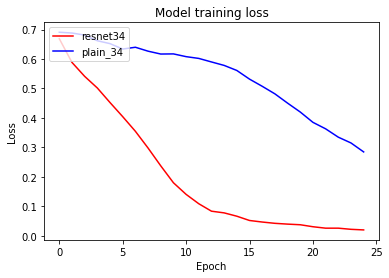

In [76]:
import matplotlib.pyplot as plt

plt.plot(resnet34_history.history['loss'], 'r')
plt.plot(plain34_history.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain_34'], loc='upper left')
plt.show()


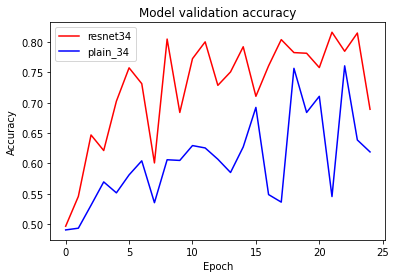

In [77]:
plt.plot(resnet34_history.history['val_accuracy'], 'r')
plt.plot(plain34_history.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain_34'], loc='upper left')
plt.show()

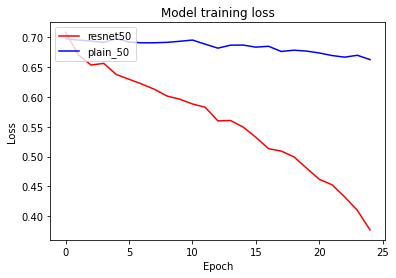

In [78]:
plt.plot(resnet50_history.history['loss'], 'r')
plt.plot(plain50_history.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain_50'], loc='upper left')
plt.show()

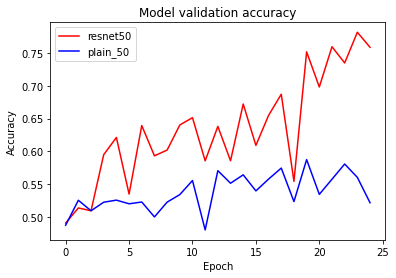

In [79]:
plt.plot(resnet50_history.history['val_accuracy'], 'r')
plt.plot(plain50_history.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain_50'], loc='upper left')
plt.show()